# REINFORCE in TensorFlow

Just like we did before for q-learning, this time we'll design a neural network to learn `CartPole-v0` via policy gradient (REINFORCE).

In [1]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it

import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=: 1


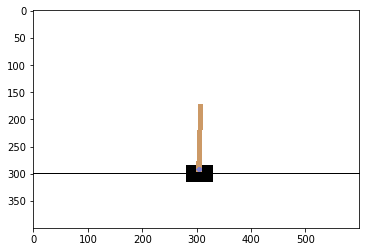

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the policy network

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__. 

We'll use softmax or log-softmax where appropriate.

In [3]:
import tensorflow as tf

# create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32', (None,)+state_dim, name="states")
actions = tf.placeholder('int32', name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [4]:
# <define network graph using raw tf or any deep learning library>
n_neurons = 40
n_states = state_dim[0]

W1 = tf.get_variable("W1", shape=[n_states, n_neurons], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b1 = tf.get_variable("b1", shape=[n_neurons], dtype=tf.float32, initializer=tf.zeros_initializer())

W2 = tf.get_variable("W2", shape=[n_neurons, n_neurons], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b2 = tf.get_variable("b2", shape=[n_neurons], dtype=tf.float32, initializer=tf.zeros_initializer())

W = tf.get_variable("W", shape=[n_neurons, n_actions], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b = tf.get_variable("b", shape=[n_actions], dtype=tf.float32, initializer=tf.zeros_initializer())

z1 = tf.nn.relu(tf.matmul(states, W1) + b1)
z2 = tf.nn.relu(tf.matmul(z1, W2) + b2)

logits = tf.matmul(z2, W) + b

policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

W0903 19:55:24.836710 140233859225344 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# utility function to pick action in one given state
def get_action_proba(s): 
    return policy.eval({states: [s]})[0]

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [6]:
# select log-probabilities for chosen actions, log pi(a_i|s_i)
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [8]:
# REINFORCE objective function
# hint: you need to use log_policy_for_actions to get log probabilities for actions taken
actions_onehot = tf.one_hot(actions, n_actions, dtype='float32')
J = - tf.reduce_mean(tf.reduce_sum(actions_onehot * log_policy, axis=1) * cumulative_rewards)  # <policy objective as in the last formula. Please use mean, not sum.>

In [9]:
# regularize with entropy
entropy = tf.reduce_mean(- policy * log_policy)

In [12]:
# weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
update = tf.train.AdamOptimizer().minimize(J)

### Computing cumulative rewards

In [13]:
def get_cumulative_rewards(rewards,    # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """

    #  <your code here>
    n_rewards = len(rewards)
    cumulative_rewards = []
    
    for i in range(n_rewards):
        cumulative_reward = rewards[i]
        weight = gamma
        for j in range(i+1, n_rewards):
            cumulative_reward += weight * rewards[j]
            weight *= gamma

        cumulative_rewards.append(cumulative_reward)
            
    return np.array(cumulative_rewards)

In [14]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
                   [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
                   [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
                   [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [15]:
def train_step(_states, _actions, _rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states: _states, actions: _actions,
                cumulative_rewards: _cumulative_rewards})

### Playing the game

In [16]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)

        a = np.random.choice(n_actions, 1, p=action_probas)[0]

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    train_step(states, actions, rewards)

    # technical: return session rewards to print them later
    return sum(rewards)

In [17]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):

    rewards = [generate_session() for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 300:
        print("You Win!") # but you can train even further
        break

mean reward:26.360
mean reward:40.810
mean reward:79.760
mean reward:100.890
mean reward:139.200
mean reward:208.870
mean reward:199.620
mean reward:132.440
mean reward:126.680
mean reward:344.930
You Win!


### Results & video

In [18]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [19]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [20]:
from submit import submit_cartpole
submit_cartpole(generate_session, "ahammer3@u.rochester.edu", "xbvrh9sxyB1GMqWo")

Submitted to Coursera platform. See results on assignment page!


In [21]:
# That's all, thank you for your attention!
# Not having enough? There's an actor-critic waiting for you in the honor section.
# But make sure you've seen the videos first.